In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram
from collections import defaultdict
from matplotlib.lines import Line2D
import numpy as np

### Helper Code

In [2]:
class DendrogramHandler:
    def __init__(self,G):
        self.G = G
        self.communities = self._getGirvanNewmanCommunities()
        self.node_id_to_children, self.node_labels = self._getNode_id_to_children_dict()
        self.subset_rank_dict = self._getSubset_rank_dict()
        self.Z, self.leaves = self._getLinkMatrix()

    """ Public methods """
    def getLinkMatrix(self): return self.Z
    #def getAll(self): return self.Z, self.leaves, self.node_labels
    def getLinkMatrixLabels(self): return [self.node_labels[node_id] for node_id in self.leaves]
    #def getLeaves(self): return self.leaves
    #def getNodeLabels(self): return self.node_labels
    

    """ Private methods """
    def _getGirvanNewmanCommunities(self):
        # Get communities using edge betweenness algorithm from Girvan and Newman
        communities = list(nx.algorithms.community.centrality.girvan_newman(self.G))
        #tuple(sorted(c) for c in communities) # uncomment if you want to print out set of ocmmunities
        return communities
    def _getNode_id_to_children_dict(self):
        node_id = 0
        init_node2community_dict = {node_id: self.communities[0][0].union(self.communities[0][1])}
        for comm in self.communities:
            for subset in list(comm):
                if subset not in init_node2community_dict.values():
                    node_id += 1
                    init_node2community_dict[node_id] = subset

        # turning this dictionary to the desired format in @mdml's answer
        node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
        for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
            for node_id_parent, group in init_node2community_dict.items():
                if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
                    node_id_to_children[node_id_parent].append(node_id1)
                    node_id_to_children[node_id_parent].append(node_id2)
        
        # also recording node_labels dict for the correct label for dendrogram leaves
        node_labels = dict()
        for node_id, group in init_node2community_dict.items():
            if len(group) == 1:
                node_labels[node_id] = list(group)[0]
            else:
                node_labels[node_id] = ''
        return node_id_to_children, node_labels

    def _getSubset_rank_dict(self):
        # also needing a subset to rank dict to later know within all k-length merges which came first
        subset_rank_dict = dict()
        rank = 0
        for e in self.communities[::-1]:
            for p in list(e):
                if tuple(p) not in subset_rank_dict:
                    subset_rank_dict[tuple(sorted(p))] = rank
                    rank += 1
        subset_rank_dict[tuple(sorted(chain.from_iterable(self.communities[-1])))] = rank
        return subset_rank_dict 
    def _getLinkMatrix(self):
        # finally using @mdml's magic, slightly modified:
        G           = nx.DiGraph(self.node_id_to_children)
        nodes       = G.nodes()
        leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
        inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

        # Compute the size of each subtree
        subtree = dict( (n, [n]) for n in leaves )
        for u in inner_nodes:
            children = set()
            node_list = list(self.node_id_to_children[u])
            while len(node_list) > 0:
                v = node_list.pop(0)
                children.add( v )
                node_list += self.node_id_to_children[v]
            subtree[u] = sorted(children & leaves)

        inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

        # Construct the linkage matrix
        leaves = sorted(leaves)
        index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
        Z = []
        k = len(leaves)
        for i, n in enumerate(inner_nodes):
            children = self.node_id_to_children[n]
            x = children[0]
            for y in children[1:]:
                z = tuple(sorted(subtree[x] + subtree[y]))
                i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
                Z.append([i, j, self._get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
                index[z] = k
                subtree[z] = list(z)
                x = z
                k += 1
        return Z, leaves
    def _get_merge_height(self,sub):
        # Giora Simchoni's function to get a merge height so that it is unique (probably not that efficient)
        sub_tuple = tuple(sorted([self.node_labels[i] for i in sub]))
        n = len(sub_tuple)
        other_same_len_merges = {k: v for k, v in self.subset_rank_dict.items() if len(k) == n}
        min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
        range = (max_rank-min_rank) if max_rank > min_rank else 1
        return float(len(sub)) + 0.8 * (self.subset_rank_dict[sub_tuple] - min_rank) / range

In [4]:
class graphHandler:
    def __init__(self, G, colormap, use_pydot = True):
        self.G = G
        self.color_template = self.color_template = ['y', 'b', 'm', 'c', 'k'] 
        self.color_map = colormap
        if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')
        else: self.pos = nx.nx_agraph.graphviz_layout(self.G,prog='neato')
    ####################
    ## Public methods ##
    ####################
    def getGraph(self): return self.G
    def showGraph(self,agent_colors = None,title = None):
        if agent_colors == None: agent_colors = self.color_map
        if title == None: title = "Network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
    def showLouvainCommunities(self, title = None):
        agent_colors = self._getAgentColors_from_LouvainCommunities()
        if title == None: title = "Louvain communities for network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
    def showDendrogram(self):
        myHandler = DendrogramHandler(self.G)
        Z = myHandler.getLinkMatrix()
        ZLabels = myHandler.getLinkMatrixLabels()
        #plt.figure(figureNumber);plt.clf()
        dendrogram(Z, labels=ZLabels)
        del myHandler
    def show_kCores(self):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # compute position of each node with shell layout
        pos = nx.layout.shell_layout(self.G, sorted(list(kcores.values())))
        colors = ['black','lightblue','yellow','magenta','olive', 'cyan']
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(list(kcores.keys()),reverse = True):
            nodes = kcores[kcore]
            nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=colors[kcore%len(colors)])
            label = f"kcore = {kcore}"
            color = colors[kcore%len(colors)]
            legend_elements.append(Line2D([0], [0], marker='o', color=color, label=label,markerfacecolor=color, markersize=15))
        nx.draw_networkx_edges(self.G, pos, width=0.2)
        nx.draw_networkx_labels(self.G, pos)
        plt.title("K-core layout of network")
        plt.legend(handles = legend_elements, loc = 'best')
    def show_partitions(self, partition_list, title = "Network colored by partitions"):
        plt.figure()
        plt.axis('off')
        for i in range(len(partition_list)):
            nx.draw_networkx_nodes(partition_list[i],self.pos,node_color=self.color_template[i%len(self.color_template)], alpha = 0.8)
        for edge in self.G.edges:
            self._draw_edge_by_type(edge, partition_list)
        nx.draw_networkx_labels(self.G,self.pos)
        if len(partition_list) == 0:
            mod = 0
        else:
            mod = nx.algorithms.community.quality.modularity(self.G,partition_list)
        title = title + ": Modularity = " + str(np.round(mod,2))
        plt.title(title)
    
    #####################
    ## Private methods ##
    #####################
    def _getAgentColors_from_LouvainCommunities(self):
        """ Use the Louvain partition method to break the graph into communities """
        # Louvain method pip install python-louvain
        # see https://arxiv.org/pdf/0803.0476.pdf
        # see https://github.com/taynaud/python-louvain
        color_map = self.color_map
        set_of_partitions = nx.community.louvain_communities(self.G)
        print(f"The Louvain algorithm found {len(set_of_partitions)} partitions.")
        partition_number = 0
        for partition in set_of_partitions:
            for node in partition:
                color_map[node] = self.color_template[partition_number%len(self.color_template)]
            partition_number += 1
        return color_map
    def _draw_edge_by_type(self, edge, partition):
        edge_style = 'dashed'
        for part in partition:
            if edge[0] in part and edge[1] in part:
                edge_style = 'solid'
                break
        nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)

In [5]:
class MixedNetworkFormation:
    def __init__(self, M=None, poisson_lambda = 5, num_edges = 200):
        ### Initialize Algorithm with four types using Equation 3 ###
        if M is None:
            self.M = np.array([[0.4, 0.02, 0.01, 0.03],
                [0.02, 0.4, 0.03, 0.02],
                [0.01, 0.03, 0.4, 0.01],
                [0.03, 0.02, 0.01, 0.4]]) # Mixing matrix
        else: self.M = M

        # Number of node types equals dimension of M matrix
        self.type_list = [i for i in range(len(M))]
        self.color_template = ['y', 'b', 'm', 'c', 'k'] 

        # Create empty graph
        self.G = nx.Graph()
        
        # Run the algorithm
        self._AlgorithmStep1(poisson_lambda)
        self._AlgorithmStep2(num_edges)
        self._AlgorithmStep3()
        self._AlgorithmStep4()

        ### Set graph properties ### 
        self.color_map = self._getColorMap()        

    """ Public methods """
    def getGraph(self): return self.G
    def getGroundTruthColors(self): return self.color_map   
    def getColorTemplate(self): return self.color_template
    def getAverageDegree(self): return(np.average([self.G.degree(n) for n in self.G.nodes]))
    
    """ Private methods """
    ### Graph Helpers 
    def _getColorMap(self):
        color_map = []
        num_colors = len(self.color_template)
        for node in self.G.nodes: 
            color_map.append(self.color_template[self.G.nodes[node]['type']%num_colors])
        return color_map

    ### Algorithm Step 1 ###
    def _AlgorithmStep1(self, poisson_lambda):
        self.PoissonLambda = poisson_lambda
   
    ### Algorithm Step 2 ###
    def _AlgorithmStep2(self, num_edges):
        self.num_edges = num_edges # This is how many edges I want
        self.edgeNumbersDict = self._drawEdgesFromMixingMatrix()
        self.endsByTypeDict = self._countEndsOfEdgesByType()
        self.expectedNumberOfNodes = self._computeExpectedNumberOfNodes()
    def _drawEdgesFromMixingMatrix(self):
        edgeNumbersDict = dict()
        # initialize dictionary
        for type1 in self.type_list:
            for type2 in self.type_list:
                if type2>=type1:
                    edgeNumbersDict[(type1,type2)] = 0
        count = 0
        while count < self.num_edges:
            for type1 in self.type_list:
                for type2 in self.type_list:
                    if np.random.uniform(low=0.0,high=1.0) < self.M[type1][type2]:
                        if type2 >= type1: edgeNumbersDict[(type1,type2)] += 1
                        else: edgeNumbersDict[(type2,type1)] += 1
                        count+=1
        #(edgeNumbersDict)
        #print("There are ", sum([edgeNumbersDict[key] for key in edgeNumbersDict.keys()])," edges in the dictionary")
        return edgeNumbersDict
    def _countEndsOfEdgesByType(self):
        endsByTypeDict = {k: 0 for k in self.type_list} # initialize dictionary
        for type1 in self.type_list:
            for type2 in self.type_list:
                if type2<type1: continue
                if type1 == type2: endsByTypeDict[type1] += self.edgeNumbersDict[(type1,type2)]*2
                else: 
                    endsByTypeDict[type1] += self.edgeNumbersDict[(type1,type2)]
                    endsByTypeDict[type2] += self.edgeNumbersDict[(type1,type2)]
        #print("node ends by type ", endsByTypeDict)
        return endsByTypeDict
    def _computeExpectedNumberOfNodes(self):
        numNodeDict = dict()
        for type in self.type_list:
            n = np.round(self.endsByTypeDict[type]/self.PoissonLambda)
            #print(int(n))
            numNodeDict[type] = int(n)
        return numNodeDict

    ### Algorithm Step 3 ###
    def _AlgorithmStep3(self):
        self.nodeListByTypeAndDegree = self._drawNodesFromTypes()
    def _drawNodesFromTypes(self):
        nodesByDegreeDict = {k: [] for k in self.type_list} # initialize to dictionary of empty lists
        for type in self.type_list:
            nodeList = self._drawNodesByType(type)
            nodesByDegreeDict[type] = nodeList
        #print("nodesByDegreeDict = ", nodesByDegreeDict) 
        return nodesByDegreeDict  
    def _drawNodesByType(self,type):
        nodeList = list()
        #print("Trying to get ", self.endsByTypeDict[type]," total degrees")
        while len(nodeList) != self.expectedNumberOfNodes[type]:
            if len(nodeList) < self.expectedNumberOfNodes[type]:
                node = np.random.poisson(lam=self.PoissonLambda)
                if node==0: continue
                nodeList.append(node)
            #print("Number of nodes in node set ", type, " is ", sum(nodeList))
            if len(nodeList) > self.expectedNumberOfNodes[type]:
                nodeList.pop(0)
                #print("Number of nodes in node set ", type, " is ", sum(nodeList))
        #print("Length of nodeList for type ",type, " = ",len(nodeList))
        return nodeList

    ### Algorithm Step 4 ###
    def _AlgorithmStep4(self):
        self._addNodesToGraph()
        self._addEdgesToGraph() # Requires nodes to be added to graph
    def _addNodesToGraph(self):
        # Make the node list into a a format with node_id by type
        nodeList = []
        nodeID = 0
        for type in self.type_list:
            for nodeDegree in self.nodeListByTypeAndDegree[type]:
                nodeList.append((nodeID, {"type":type, "degree":nodeDegree}))
                nodeID += 1
        #print("node list is ", nodeList)
        self.G.add_nodes_from(nodeList)
        return nodeList
    def _addEdgesToGraph(self):
        #print("Adding edges to graph")
        for edge_type in self.edgeNumbersDict.keys():
            type1 = edge_type[0]; type2 = edge_type[1]
            while self.edgeNumbersDict[edge_type] > 0 :
                free_agents1 = self._getFreeAgents(type1)
                free_agents2 = self._getFreeAgents(type2)
                if free_agents1 == [] or free_agents2 == []: break
                node1 = free_agents1[np.random.randint(0,len(free_agents1))]
                neighbors_of_node = [n for n in self.G[node1]]
                neighbors_of_node.append(node1) # If same type, don't allow self loops
                possible_neighbors = list(set(free_agents2) - set(neighbors_of_node))
                if possible_neighbors == []: break
                index2 = np.random.randint(0,high=len(possible_neighbors))
                node2 = possible_neighbors[index2]
                self.G.add_edge(node1,node2)
                self.edgeNumbersDict[edge_type] -= 1
                self._decrementRemainingDegree(node1)
                self._decrementRemainingDegree(node2)
        #print("Done adding edges to graph")
        return 
    def _getFreeAgents(self,type):
        # return agents of specified type that have free stubs
        #print("Graph node info is ", self.G.nodes.data())
        nodes = []
        for node in self.G.nodes.data():
            node_info = list(node)
            node_index = node_info[0]
            node_degree = node_info[1]['degree']
            node_type = node_info[1]['type']
            if node_type == type and node_degree > 0: nodes.append(node_index)
        return nodes
    def _decrementRemainingDegree(self,node_index):
        # subtract one from the nodeList
        self.G.nodes[node_index]['degree'] -= 1
        #print("node ", node_index, " now has remaining degree ", self.G.nodes[node_index]['degree'], "\n\n")
        return

In [6]:
def get_arg_max_real(x):
    index = 0
    M = -np.inf
    for i in range(len(x)):
        if np.real(x[i])> M:
            M = np.real(x[i])
            index=i
    return index

def get_arg_max_modulus(x):
    index = 0
    M = -np.inf
    for i in range(len(x)):
        if x[i]>= M:
            M = x[i]
            index=i
    return index

def get_leading_eigenvector(B):
    [vals,vecs] = np.linalg.eig(B)
    # If no positive eigenvalues, to within round off error
    if all(v < 1e-4 for v in list(vals)): 
        ones = np.ones((1,len(B))) / np.sqrt(len(B)) # Normalized vector of all 1's
        max_vec = ones[0,:]
    else:
        arg_max = get_arg_max_real(vals)
        max_vec = np.real(vecs[:,arg_max])
    return max_vec

def get_principal_eigenvector(A):
    [vals,vecs] = np.linalg.eig(A)
    arg_max = get_arg_max_modulus(vals)
    max_vec = vecs[:,arg_max]
    return max_vec

def get_shores_from_eigenvector(nodes,x):
    shore1 = set()
    shore2 = set()
    for node in nodes:
        if x[node] < 0: shore1.add(node)
        else: shore2.add(node)
    return [shore1, shore2]

### Graph with Communities

##### Step 1

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


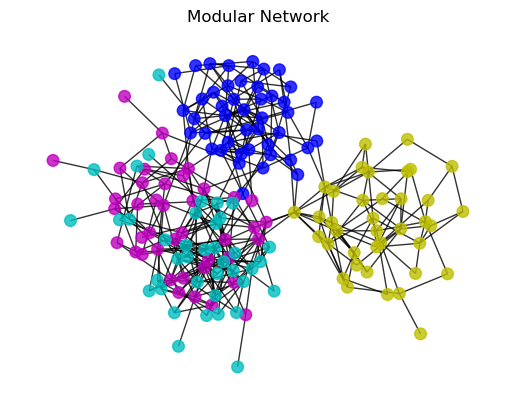

In [14]:
M = np.array([[0.4, 0.01, 0.02, 0.01],
                [0.01, 0.4, 0.02, 0.01],
                [0.02, 0.01, 0.2, 0.2],
                [0.01, 0.02, 0.2, 0.2]])

modular_network = MixedNetworkFormation(M=M, num_edges=400)
#### Set use_pydot = False if graphviz is working on your computer
modular_graph_handler = graphHandler(modular_network.getGraph(), modular_network.getGroundTruthColors(), use_pydot=True)
modular_graph_handler.showGraph(title="Modular Network")

##### Step 2

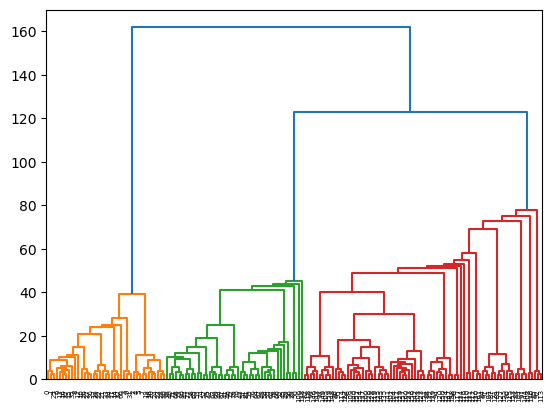

In [15]:
modular_graph_handler.showDendrogram()

##### Step 3

Based on the dendrogram from the previous step, it looks like this is more of an affinity network.

##### Step 4

From the dendrogram, we can see that there appear to be at least three distinct clusers, possibly with a fourth (one could argue that the third/red cluster on the right could be broken into two smaller clusters).  Furthermore, the first two clusters (orange and green) appear to be about the same size, and the third is about twice the size of the first two.  Finally, there are no splits on either end of the dendrogram.  In summary, the dendrogram does not seem to show core and periphery groups, but there do appear to be three or four communities.

##### Step 5

The Louvain algorithm found 5 partitions.


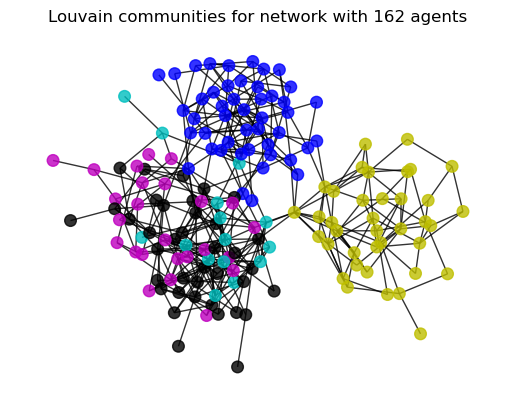

In [16]:
modular_graph_handler.showLouvainCommunities()

##### Step 6

The plot from the Louvain algorithm appears to support my hypothesis.  This looks more like an affinity network than a core-periphery network.

##### Step 7

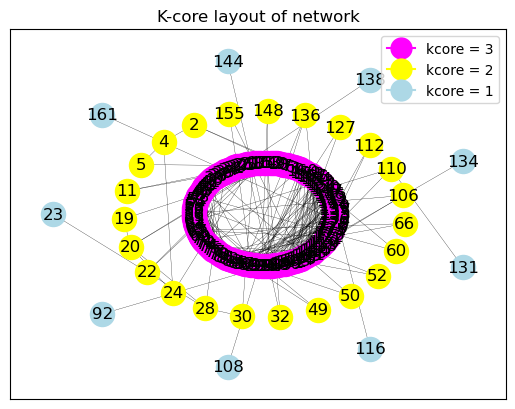

In [17]:
modular_graph_handler.show_kCores()

##### Step 8

I think that the k-core plot from the previous step somewhat supports my hypothesis.  While there is a large core (k = 3), there are also several nodes outside of the core, both in the k = 2 and k = 1 groups, indicating that there maybe is not a clear, distinct separation from core nodes and periphery nodes.

##### Step 9

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:95: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)


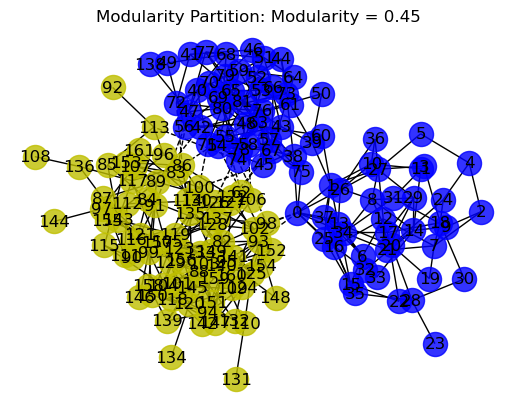

In [18]:
G = modular_network.getGraph()
B = nx.modularity_matrix(G)
x = get_leading_eigenvector(B)
partition = get_shores_from_eigenvector(list(G.nodes), x)
modular_graph_handler.show_partitions(partition, title="Modularity Partition")

##### Step 10

From the previous plot, we can see that modularity is "not small" and that the partition creates two distinct communities; I feel that these observations support my hypothesis.

##### Step 11

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:95: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)


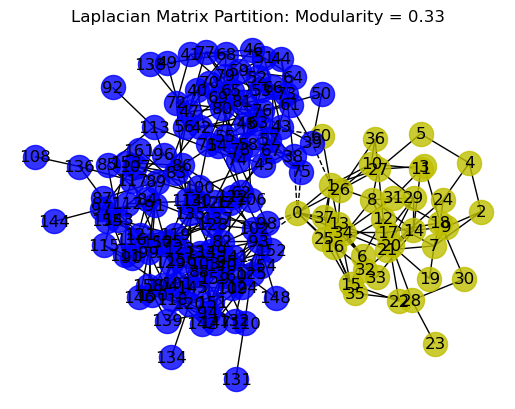

In [19]:
x = nx.fiedler_vector(G)
partition = get_shores_from_eigenvector(list(G.nodes), x)
modular_graph_handler.show_partitions(partition, title="Laplacian Matrix Partition")

##### Step 12

Similar to the plot from step 9, the plot from step 11 shows a clear separation of the two communities in the partition, which seems to support my hypothesis.

### Graph with a Core-Periphery Structure

##### Step 1

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


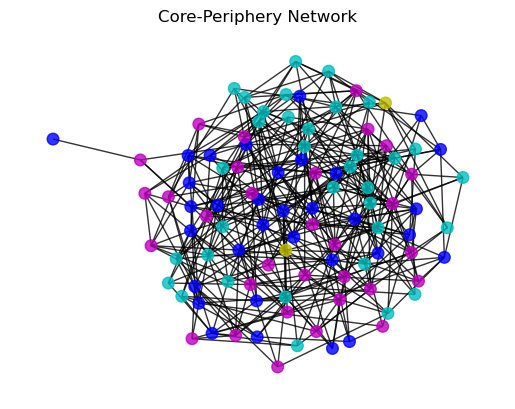

In [29]:
M = np.array([[0.01, 0.01, 0.01, 0.05],
                [0.01, 0.4, 0.4, 0.4],
                [0.01, 0.4, 0.4, 0.4],
                [0.05, 0.4, 0.4, 0.4]])
core_periphery_network = MixedNetworkFormation(M=M, poisson_lambda=8, num_edges=400)
#### Set use_pydot = False if graphviz is working on your computer
core_periphery_graph_handler = graphHandler(core_periphery_network.getGraph(), core_periphery_network.getGroundTruthColors(), use_pydot=True)
core_periphery_graph_handler.showGraph(title="Core-Periphery Network")

##### Step 2

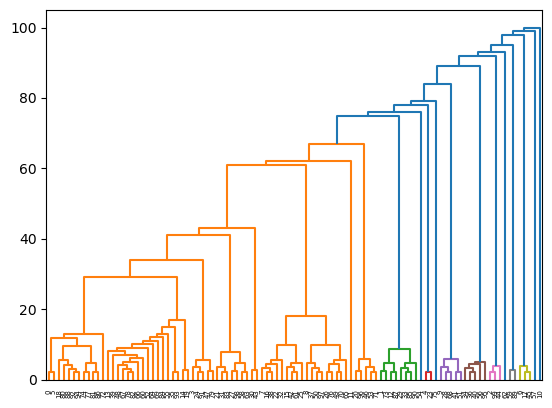

In [30]:
core_periphery_graph_handler.showDendrogram()

##### Step 3

I would say that this network is better described as a core periphery network.

##### Step 4

From the dendrogram in step 2, we can see that there appear to be two main communities, orange and blue.  Orange looks to be larger and more central than blue, which seems to indicate a core group of nodes and a group of periphery nodes.

##### Step 5

The Louvain algorithm found 7 partitions.


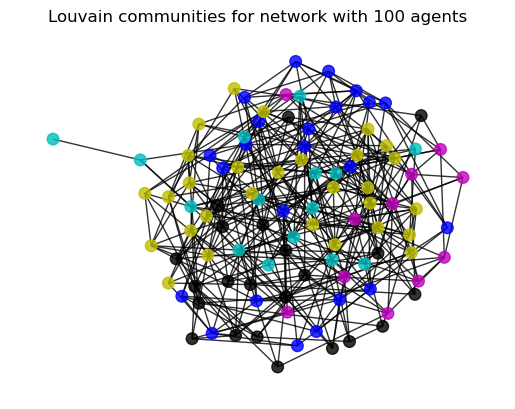

In [31]:
core_periphery_graph_handler.showLouvainCommunities()

##### Step 6

The plot from the previous step seems to support my hypothesis.  We can see that there don't appear to be any clear distinctions/separations between communities (the graph is a "jumbled mess").

##### Step 7

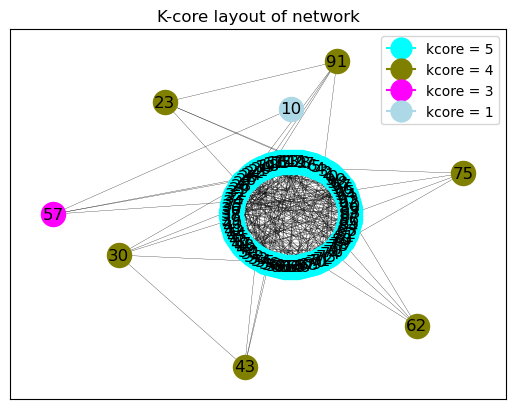

In [32]:
core_periphery_graph_handler.show_kCores()

##### Step 8

The plot from the previous step also seems to support my hypothesis.  There is a clear central core (k = 5) with only a handful of nodes in other cores.  If we compare this k-core plot with that of the previous network, we can see that here there are fewer nodes outside of the core.

##### Step 9

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:95: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)


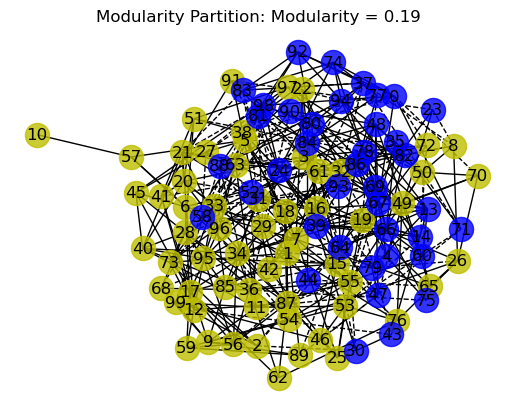

In [33]:
G = core_periphery_network.getGraph()
B = nx.modularity_matrix(G)
x = get_leading_eigenvector(B)
partition = get_shores_from_eigenvector(list(G.nodes), x)
core_periphery_graph_handler.show_partitions(partition, title="Modularity Partition")

##### Step 10

The previous also seems to support my hypothesis.  There is not a very clear separation between the two communities in the partition, and the modularity is somewhat small.

##### Step 11

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:95: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)


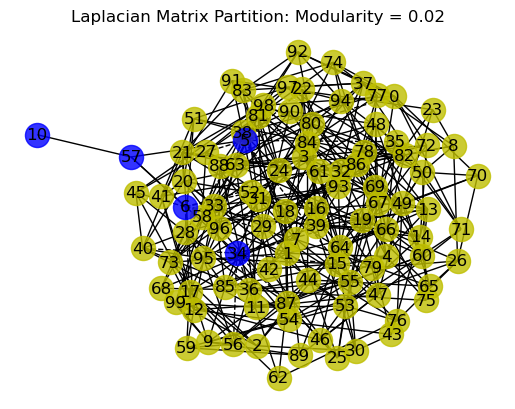

In [34]:
x = nx.fiedler_vector(G)
partition = get_shores_from_eigenvector(list(G.nodes), x)
core_periphery_graph_handler.show_partitions(partition, title="Laplacian Matrix Partition")

##### Step 12

Similar to the plot from step 9, the plot from step 11 does not show a very clear separation between the two communities in the partition.  Additionally, the modularity is even smaller in this scenario.  If we look the blue nodes, we can see that some of them are outside the central core from the k-core plot (step 7).  These observations seem to support my hypothesis.

### Karate Network

##### Step 1

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


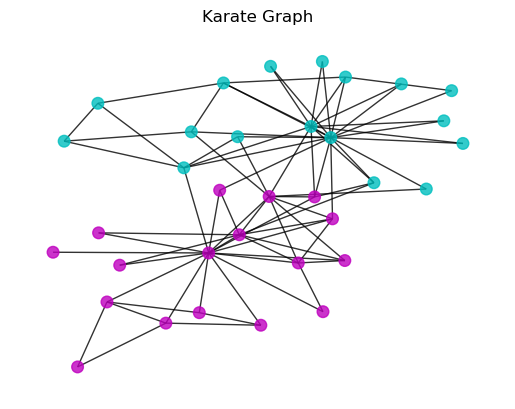

In [35]:
G = nx.karate_club_graph()
colors = ['c' if G.nodes[node]['club'] == 'Officer' else 'm' for node in G.nodes]
#### Set use_pydot = False if graphviz is working on your computer
karate_graph_handler = graphHandler(G, colors, use_pydot=True)
karate_graph_handler.showGraph(title="Karate Graph")

##### Step 2

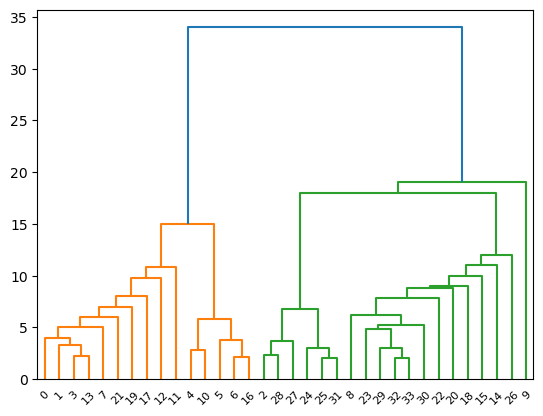

In [36]:
karate_graph_handler.showDendrogram()

##### Step 3

I hypothesize that the karate network is more of an affinity network.

##### Step 4

From the dendrogram in step 2, it looks like there are two main communities, orange and green.  The communities also appear to be roughly the same size.  In other words, it does not look like there is a large central community with a few nodes existing outside of that central community.

##### Step 5

The Louvain algorithm found 4 partitions.


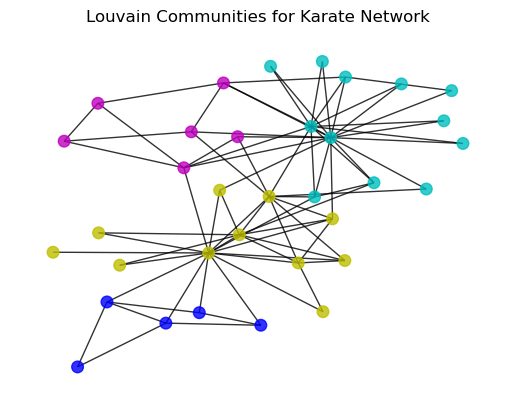

In [37]:
karate_graph_handler.showLouvainCommunities(title="Louvain Communities for Karate Network")

##### Step 6

Even though the plot seems to show four distinct communities (instead of two), it still seems to support my hypothesis that this is more of an affinity network, because we can see fairly clear separation between the communities.

##### Step 7

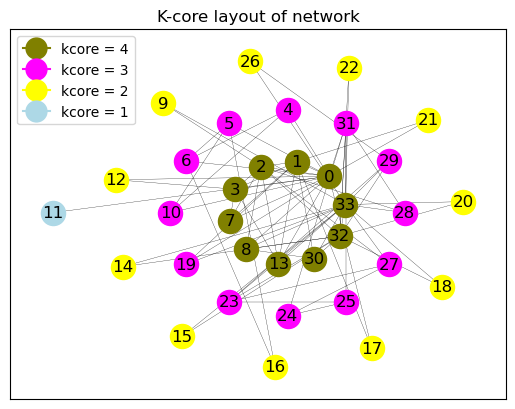

In [38]:
karate_graph_handler.show_kCores()

##### Step 8

The k-core plot from the previous step also seems to support my hypothesis.  There does not appear to be a large central core, and there are numerous nodes on the fringe.

##### Step 9

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:95: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)


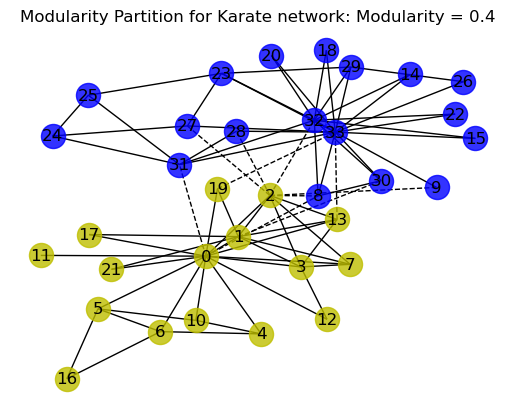

In [39]:
G = karate_graph_handler.getGraph()
B = nx.modularity_matrix(G)
x = get_leading_eigenvector(B)
partition = get_shores_from_eigenvector(list(G.nodes), x)
karate_graph_handler.show_partitions(partition, title="Modularity Partition for Karate network")

##### Step 10

The plot from the previous step also seems to support my hypothesis.  We can see a clear separation between the two communities in the partition.  Additionally, the modularity is "not small".

##### Step 11

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:95: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)


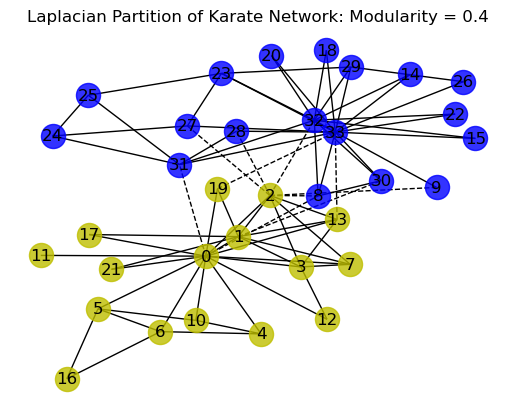

In [40]:
x = nx.fiedler_vector(G)
partition = get_shores_from_eigenvector(list(G.nodes), x)
karate_graph_handler.show_partitions(partition, title="Laplacian Partition of Karate Network")

##### Step 12

Similar to the plot from step 9, the plot from step 11 shows a clear separation between the two communities in the partition.  Furthermore, the modularity score is the same and is "not small".  So, this plot also appears to support my hypothesis.

##### Step 13

In summary, I would say that my hypothesis was correct and the karate network does indeed appear to be an affinity network.  From the dendogram, there appear to be two key communities (which is also a reflection of the two different karate clubs).  We also saw clear separation of communities with the modularity and Laplacian paritions.  However, one could maybe argue that the k-core plot indicates that there are handful of central nodes (i.e. club leaders) and at least one periphery node (node 11; see step 7).

### Les Miserables Network

##### Step 1

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


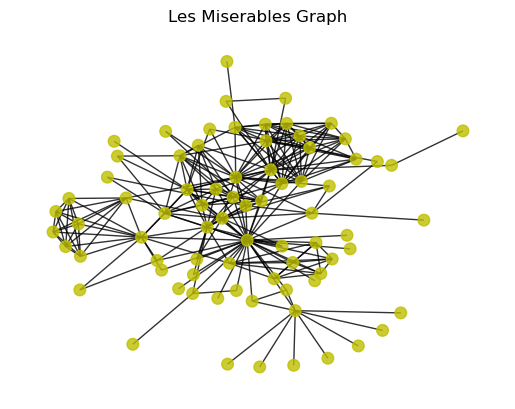

In [41]:
G = nx.les_miserables_graph()
colors = ['y' for node in G.nodes]
#### Set use_pydot = False if graphviz is working on your computer
LesMiserables_graph_handler = graphHandler(G, colors, use_pydot=True)
LesMiserables_graph_handler.showGraph(title="Les Miserables Graph")

##### Step 2

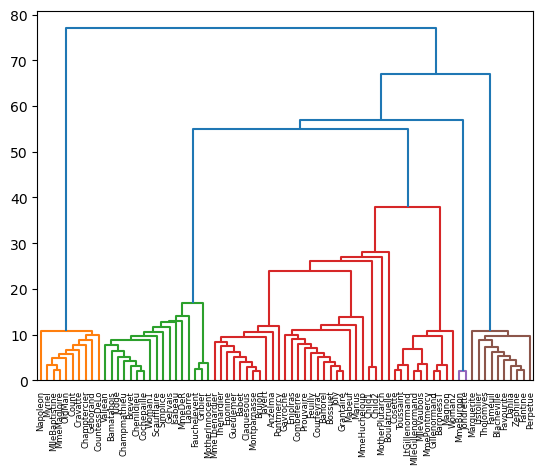

In [42]:
LesMiserables_graph_handler.showDendrogram()

##### Step 3

I hypothesize that this is more of a core-periphery network.

##### Step 4

From the dendrogram in step 2, it looks like there is a large, central group (red) with perhaps three other smaller groups on the edges (orange, green, and brown).

##### Step 5

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


The Louvain algorithm found 6 partitions.


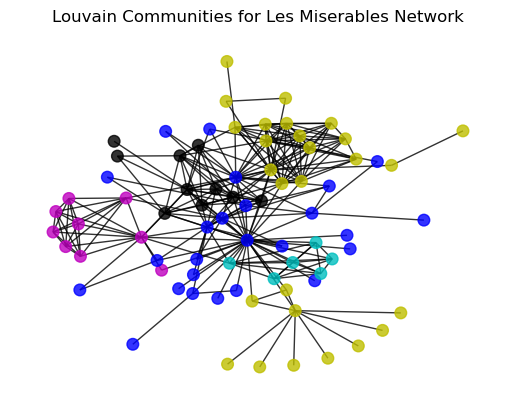

In [43]:
H = nx.convert_node_labels_to_integers(G)
LesMiserables_graph_handler2 = graphHandler(H, colors, use_pydot=True)
LesMiserables_graph_handler2.showLouvainCommunities(title="Louvain Communities for Les Miserables Network")

##### Step 6

The plot from step 5 is unique in the sense that I feel it neither supports nor refutes my hypothesis.  It seems like there are some clear communities closer to the edges of the network (which probably refutes my hypothesis), but in the middle there is more of a "jumbled mess" (which probably supports my hypothesis).

##### Step 7

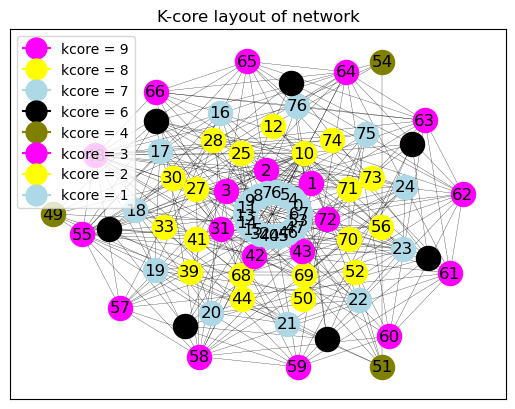

In [44]:
LesMiserables_graph_handler2.show_kCores()

##### Step 8

I think the k-core plot from the previous step refutes my hypothesis.  There does not appear to be a particularly strong/large central core, and there are numerous nodes that exist in periphery cores.

##### Step 9

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:95: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)


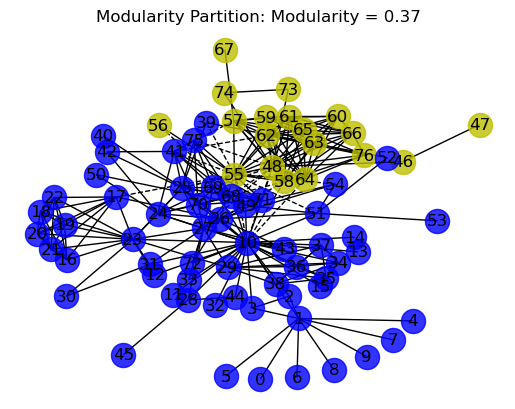

In [46]:
G = LesMiserables_graph_handler2.getGraph()
B = nx.modularity_matrix(G)
x = get_leading_eigenvector(B)
partition = get_shores_from_eigenvector(list(G.nodes), x)
LesMiserables_graph_handler2.show_partitions(partition, title="Modularity Partition")

##### Step 10

I think the previous plot also refutes my hypothesis.  It looks like there is a farily clear separation/dinstiction between the two communities in the partition, and the modularity score is "not small".

##### Step 11

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_11082/1583106224.py:95: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)


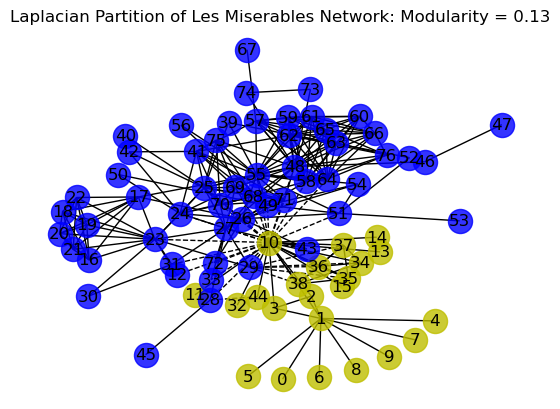

In [47]:
x = nx.fiedler_vector(H)
partition = get_shores_from_eigenvector(list(H.nodes), x)
LesMiserables_graph_handler2.show_partitions(partition, title="Laplacian Partition of Les Miserables Network")

##### Step 12

Similar to the plot from step 9, I would say that this plot mainly refutes my hypothesis.  There appears to be a somewhat clear separation between the two communities in the partition; however, the modularity score is smaller in this case, which perhaps lends minor support to my hypothesis.

##### Step 13

After observing and thinking about the previous steps, I would say that this network is more of a hybrid between an affinity network and a core-periphery network.  I originally hypothesized that it was a core-periphery network because the dendrogram showed a larger, central cluser with smaller clusters on the edges.  I think that this perhaps shows that there are several main characters with other supporting characters.  However, after observing the other plots (k-cores, Louvain, and partitions), it seems that, while there are central characters, they are either not central enough or the supporting/edge characters are common/prevalent enough to, at least somewhat, create communities.